In [232]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


import matplotlib.pyplot as plt



In [233]:
data = pd.read_csv("out/data.csv")

data = data.drop(columns=["cases.submitter_id"])

# Step 3: Initial exploration
print("Initial data shape:", data.shape)
print(data.head())
print(data.info())
print(data['OS'].value_counts())


Initial data shape: (253, 61)
  project.project_id       cases.disease_type cases.index_date  \
0          TCGA-LUSC  Squamous Cell Neoplasms        Diagnosis   
1          TCGA-LUSC  Squamous Cell Neoplasms        Diagnosis   
2          TCGA-LUSC  Squamous Cell Neoplasms        Diagnosis   
3          TCGA-LUSC  Squamous Cell Neoplasms        Diagnosis   
4          TCGA-LUSC  Squamous Cell Neoplasms        Diagnosis   

  cases.primary_site  demographic.age_at_index  demographic.age_is_obfuscated  \
0  Bronchus and lung                      67.0                          False   
1  Bronchus and lung                      72.0                          False   
2  Bronchus and lung                      74.0                          False   
3  Bronchus and lung                      81.0                          False   
4  Bronchus and lung                      63.0                          False   

  demographic.country_of_residence_at_enrollment  demographic.days_to_birth  \
0      

In [234]:
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = data[col].astype(str)



In [235]:
num_cols = data.select_dtypes(include=[np.number]).columns
cat_cols = data.select_dtypes(include=['object']).columns


In [236]:
num_imputer = SimpleImputer(strategy='median')
for col in num_cols:
    if pd.api.types.is_numeric_dtype(data[col]):
        data[col] = data[col].astype(float)
        data[col] = num_imputer.fit_transform(data[[col]])


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['diagnoses.tumor_of_origin']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [237]:
if len(cat_cols) > 0:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    data[cat_cols] = pd.DataFrame(
        cat_imputer.fit_transform(data[cat_cols]),
        columns=cat_cols,
        index=data.index
    )


In [238]:
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    le_dict[col] = le


In [239]:
X = data.drop('OS', axis=1)
y = data['OS']  # make sure OS is categorical (0/1)

scaler = StandardScaler()
X = scaler.fit_transform(X)

# 3. Create and fit PCA
pca = PCA(n_components=10)  # reduce to 2 dimensions
X = pca.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [240]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [241]:
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [242]:
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.6666666666666666
Classification Report:
               precision    recall  f1-score   support

         0.0       0.65      0.62      0.64        24
         1.0       0.68      0.70      0.69        27

    accuracy                           0.67        51
   macro avg       0.67      0.66      0.66        51
weighted avg       0.67      0.67      0.67        51

Confusion Matrix:
 [[15  9]
 [ 8 19]]


In [243]:
y_prob = clf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC:", roc_auc)


ROC-AUC: 0.6782407407407407


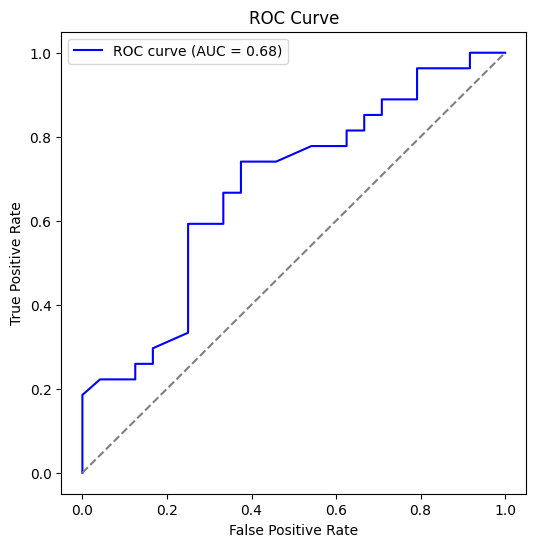

In [244]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [245]:
importances = clf.feature_importances_
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
print("Top 10 important features:\n", feature_importance_df.head(10))


AttributeError: 'numpy.ndarray' object has no attribute 'columns'